In [478]:
import os
import random

from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

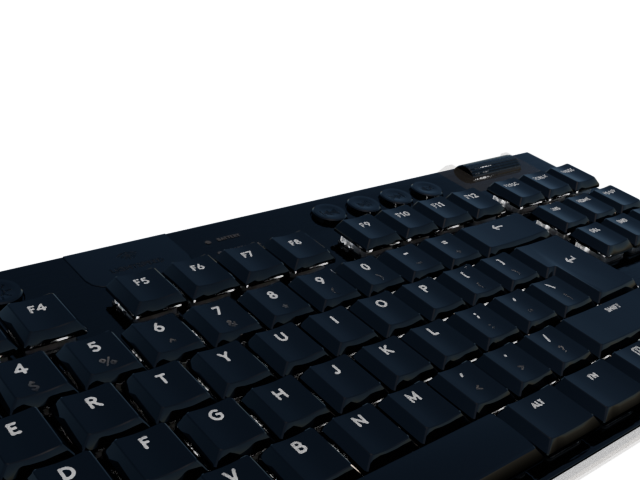

In [486]:
frame = 24

path = "keyboard_{'sun_intensity': 1.0, 'sun_elevation': 70.0, 'sun_rotation': 180.0, 'strength': 0.1}"
image = Image.open(f"blender/renders/{path}_{frame:03d}.png")
image

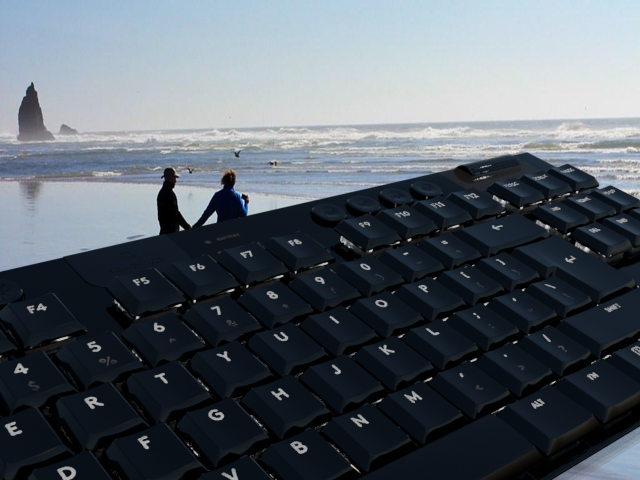

In [508]:
path = random.choice(os.listdir("assets/backgrounds"))
background = Image.open(f"assets/backgrounds/{path}")
background = background.resize(image.size)
background.paste(image, mask=image)
background

In [509]:
# See https://medium.com/@itberrios6/how-to-apply-motion-blur-to-images-75b745e3ef17

def get_motion_blur_kernel(theta, thickness=1, ksize=21):
    """ Obtains Motion Blur Kernel
    
    @param theta - direction of blur
    @param thickness - thickness of blur kernel line
    @param ksize - size of blur kernel
    """
    c = ksize // 2
    
    theta = np.radians(theta)
    x = int(np.cos(theta) * 100)
    y = int(np.sin(theta) * 100)
    
    _kernel = np.zeros((ksize, ksize))
    _kernel = cv.line(_kernel, (c + x, c + y), (c, c), (1, ), thickness)
    return _kernel / _kernel.sum()


def get_vignette_kernel(sigma):
    _kernel_x = cv.getGaussianKernel(image.size[0], sigma)
    _kernel_y = cv.getGaussianKernel(image.size[1], sigma)
    _kernel = _kernel_y * _kernel_x.T
    
    _kernel /= _kernel.max()
    return np.repeat(_kernel[:, :, np.newaxis], 3, axis=2)
    

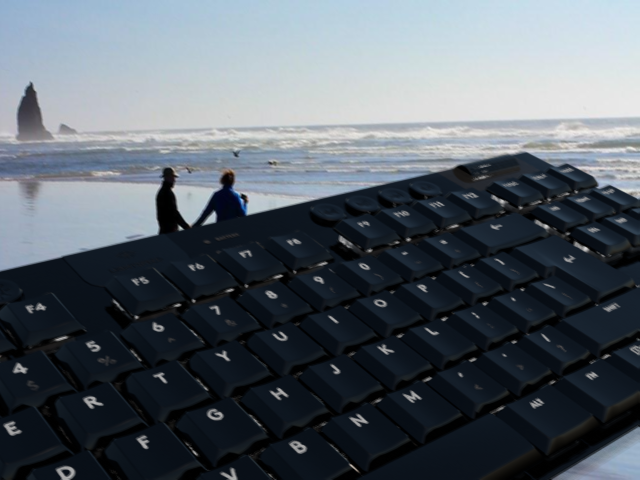

In [514]:
# Greater ksize = more motion blur
# Greater thickness = more gaussian blur

blur_kernel = get_motion_blur_kernel(theta=30, thickness=1, ksize=6)
blurred = cv.filter2D(np.array(background), ddepth=-1, kernel=blur_kernel)
Image.fromarray(blurred)

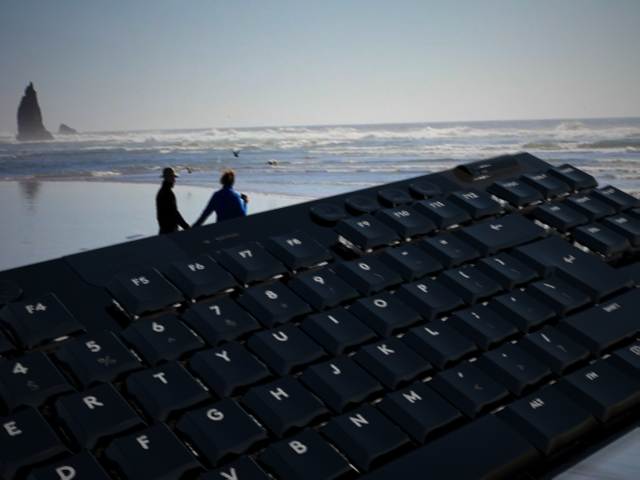

In [525]:
mask = get_vignette_kernel(400)
vignetted = (mask * blurred).astype("uint8")
vignetted = Image.fromarray(vignetted)
vignetted

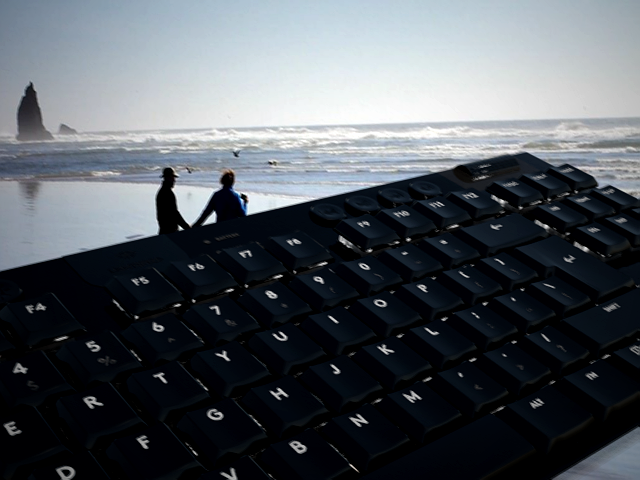

In [788]:
output = vignetted.copy()

contrast, exposure, sharpness, saturation = np.random.normal(loc=1.0, scale=0.5, size=4)
exposure = max(exposure, 0.4)
contrast = max(contrast, 0.2)

output = ImageEnhance.Contrast(output).enhance(contrast)
output = ImageEnhance.Brightness(output).enhance(exposure)
output = ImageEnhance.Sharpness(output).enhance(sharpness)
output = ImageEnhance.Color(output).enhance(saturation)
output

In [ ]:
from tqdm.notebook import tqdm

N = 1000
images = os.listdir("blender/renders")
backgrounds = os.listdir("assets/backgrounds")
vignettes = [get_vignette_kernel(i) for i in range(300, 600, 100)]

for i in tqdm(range(N)):
    path = random.choice(images)
    image = Image.open(f"blender/renders/{path}")
    
    background = Image.open(f"assets/backgrounds/{random.choice(backgrounds)}")
    background = background.resize(image.size)
    background.paste(image, mask=image)

    blur_kernel = get_motion_blur_kernel(theta=random.randint(0, 360), thickness=1, ksize=random.randint(4, 16))
    output = cv.filter2D(np.array(background), ddepth=-1, kernel=blur_kernel)

    vignette_kernel = random.choice(vignettes)
    output = (mask * output).astype("uint8")
    
    contrast, exposure, sharpness, saturation = np.random.normal(loc=1.0, scale=0.5, size=4)
    exposure = max(exposure, 0.4)
    contrast = max(contrast, 0.2)

    output = Image.fromarray(output)
    output = ImageEnhance.Contrast(output).enhance(contrast)
    output = ImageEnhance.Brightness(output).enhance(exposure)
    output = ImageEnhance.Sharpness(output).enhance(sharpness)
    output = ImageEnhance.Color(output).enhance(saturation)
    
    output_path = f"assets/keyboards/{path[-7:-3]}_{i}.png"
    output.save(output_path)

  0%|          | 0/1000 [00:00<?, ?it/s]